In [1]:
# Import libraries
import numpy as np
import geopandas as gpd
import momepy
import networkx as nx
# import pandas as pd
# import shapely
# import shapely.geometry as sg
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from lmzintgraf_gp_pref_elicit import dataset, gaussian_process, acquisition_function
from lmzintgraf_gp_pref_elicit.gp_utilities import utils_ccs as utils_ccs
from lmzintgraf_gp_pref_elicit.gp_utilities import utils_data as utils_data
from lmzintgraf_gp_pref_elicit.gp_utilities import utils_experiment as utils_experiment
from lmzintgraf_gp_pref_elicit.gp_utilities import utils_parameters as utils_parameters
from lmzintgraf_gp_pref_elicit.gp_utilities import utils_user as utils_user

In [2]:
map = gpd.read_file("Sidewalk_width_crossings_smaller.geojson") #smaller ~180 nodes

# Objectives
objective1 = map['length']
objective2 = map['crossing']
objective3 = map['obstacle_free_width']

objectives = ('length', 'crossing')

In [3]:
# Create a NetworkX graph from the map
G = momepy.gdf_to_nx(map, approach='primal')
nodes = G.nodes
# print(len(nodes))
edges = G.edges
# print(len(max(nx.connected_components(G), key=len)))

/usr/local/anaconda3/envs/test/lib/python3.10/site-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [4]:
# #Show the map as nodes and edges
#
# from shapely.geometry import Point
# start_node = gpd.GeoDataFrame({'geometry': [Point(122245.37633330293,
#                                                   486126.8581684635)]})
# end_node = gpd.GeoDataFrame({'geometry': [Point(122320.31466476223, 486327.5294561802)]})
# fig, ax = plt.subplots(figsize=(14,14), dpi=600)
# # All nodes and edges
# nx.draw(G, {n:[n[0], n[1]] for n in list(G.nodes)}, ax=ax, node_size=3)
# # Start & end node
# start_node.plot(ax=ax, color='red')
# end_node.plot(ax=ax, color='purple')
# plt.show()

In [5]:
print(nodes)

[(122245.37633330293, 486126.8581684635), (122254.86602688645, 486129.80052856216), (122264.35426393585, 486132.74411788705), (122273.84081337851, 486135.69101398275), (122283.19823912054, 486138.9678026403), (122284.1816391946, 486139.19731384714), (122287.28805009159, 486137.97386694513), (122291.40829399273, 486140.643590483), (122289.53424561612, 486128.31132216856), (122297.7854183222, 486139.47700177913), (122301.24255780602, 486130.1701925009), (122304.47424118801, 486120.76208520425), (122256.54763350038, 486170.91398380254), (122247.04588395767, 486167.91526857053), (122237.50744934028, 486164.9669819529), (122227.969152229, 486162.0189639581), (122218.43104837791, 486159.0709819753), (122289.24584929895, 486173.25169782597), (122282.43320919861, 486172.4559260068), (122296.3898333376, 486151.2069021054), (122293.35529070727, 486160.70100324217), (122290.30564961619, 486170.1963395323), (122290.12705889999, 486148.4950394649), (122234.28219718198, 486227.4182083386), (122243.0

In [6]:
#Pick random ones or pick manually that make sense - to experiment
#Smaller map:
# S = (122245.37633330293, 486126.8581684635)
# T = (122384.20250442973, 486270.65737816785) #AxisError
# T = (122320.31466476223, 486327.5294561802) #t !=cost #output2.png
# T = (122246.77932030056, 486223.5791244763) #t = cost; output.png
S = (122245.37633330293, 486126.8581684635)
T = (122246.77932030056, 486223.5791244763)

In [7]:
import outer_loop
t, p_star, val_vector_p_star, P = outer_loop.outer(G, S, T, objectives)
print(f"Target {t}; Path {p_star} with cost {val_vector_p_star}")

DFS iterations: 21
DFS time elapsed in seconds: 0.016881942749023438
Outer-loop time elapsed in seconds: 0.046957969665527344
Target [165.21   2.  ]; Path [(122245.37633330293, 486126.8581684635), (122254.86602688645, 486129.80052856216), (122264.35426393585, 486132.74411788705), (122273.84081337851, 486135.69101398275), (122283.19823912054, 486138.9678026403), (122284.1816391946, 486139.19731384714), (122287.28805009159, 486137.97386694513), (122291.40829399273, 486140.643590483), (122297.7854183222, 486139.47700177913), (122332.49987764945, 486160.7773385103), (122328.7127865793, 486160.19348477497), (122324.68334361241, 486169.2581765358), (122320.97320132754, 486178.5199137332), (122319.70610252809, 486181.6875618371), (122286.01308887315, 486183.8814735307), (122282.69556966702, 486193.2948693236), (122279.36739295325, 486202.70485648955), (122276.034562429, 486212.11332275654), (122274.00277185065, 486217.2508821529), (122271.878266905, 486221.2167929504), (122262.38569380266, 48

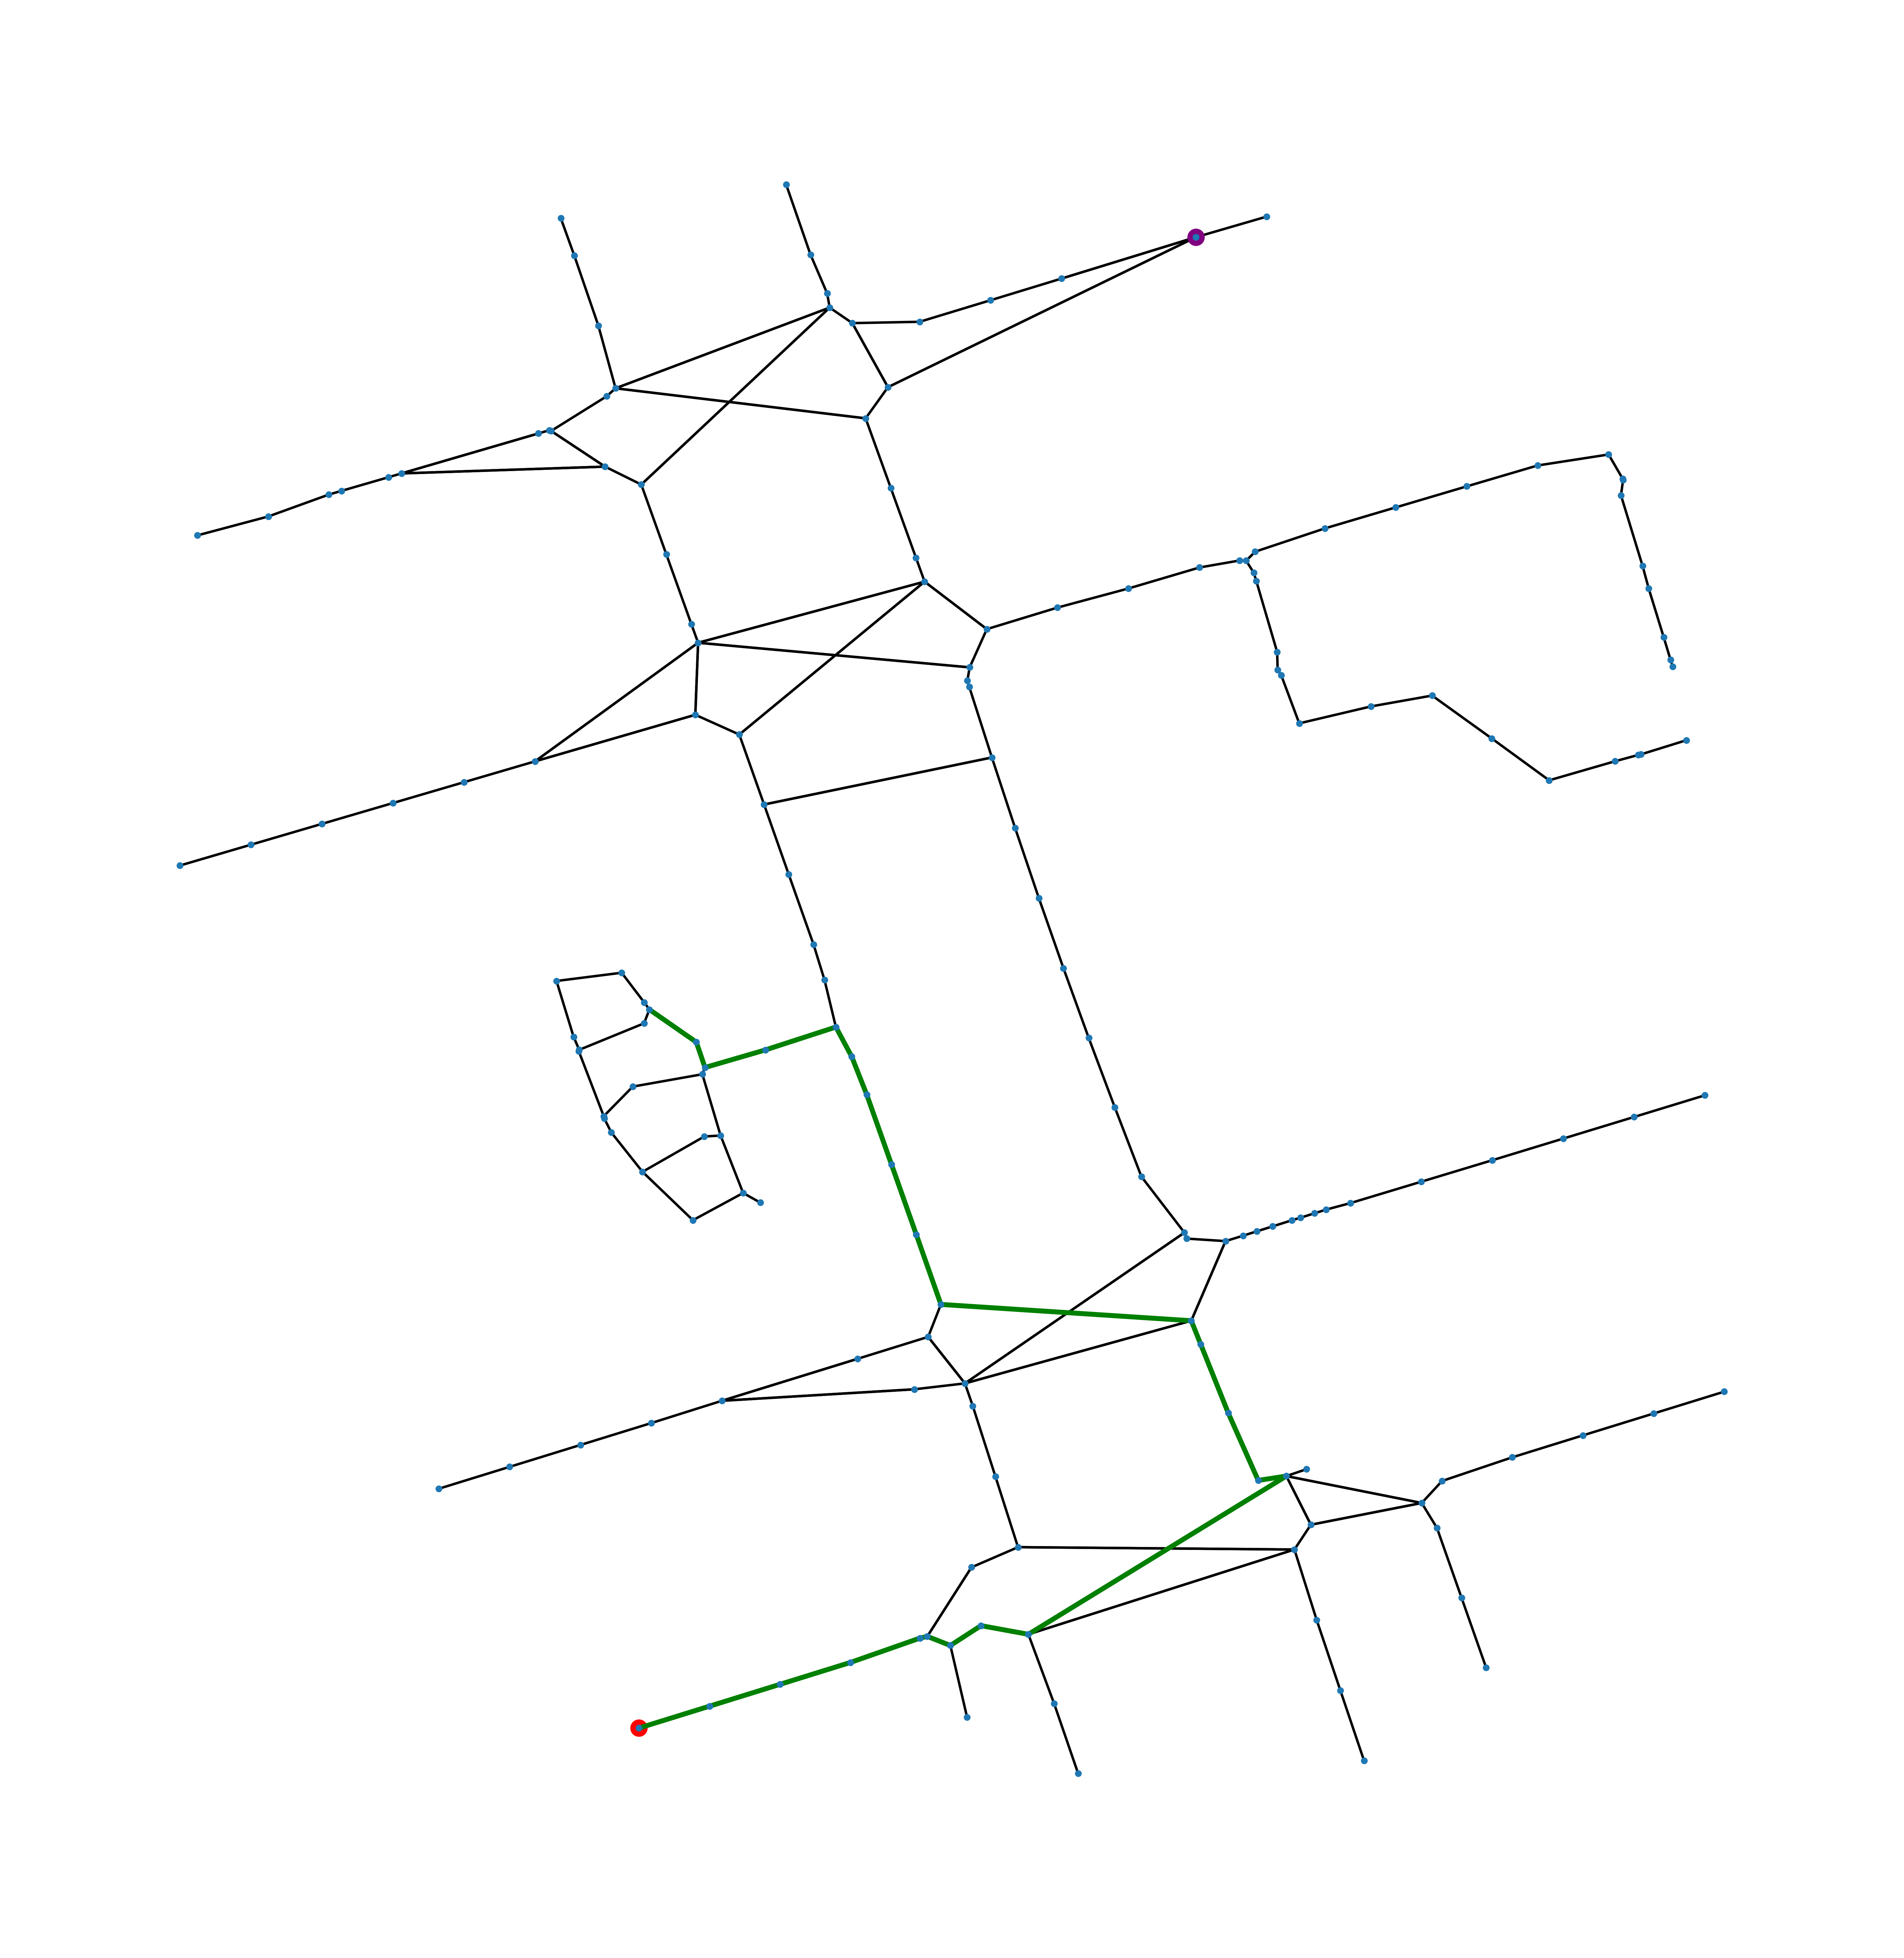

In [8]:
# Plot experiments

from shapely.geometry import Point
start_node = gpd.GeoDataFrame({'geometry': [Point(122245.37633330293,
                                                  486126.8581684635)]})
end_node = gpd.GeoDataFrame({'geometry': [Point(122320.31466476223, 486327.5294561802)]})
fig, ax = plt.subplots(figsize=(14,14), dpi=600)
# All nodes and edges
nx.draw(G, {n:[n[0], n[1]] for n in list(G.nodes)}, ax=ax, node_size=3)
# Start & end node
start_node.plot(ax=ax, color='red')
end_node.plot(ax=ax, color='purple')

# Path p_star
path_edges = list(zip(p_star[:-1], p_star[1:]))
nx.draw_networkx_edges(G, pos={n: [n[0], n[1]] for n in list(G.nodes)}, edgelist=path_edges, ax=ax, edge_color='green', width=2)



# ax.legend()
plt.show()

In [9]:
# Initialise the Gaussian process for 2 objectives
gp = gaussian_process.GPPairwise(num_objectives=2, std_noise=0.01, kernel_width=0.15, prior_mean_type='zero', seed=None)

P = []  # Pareto set
val_p = []  # value vectors w.r.t. p, i.e., v^{p_1}, v^{p_2}
val_vector_p_star = []  # value vectors w.r.t. p^*
compare_ps_pstar = []

# Path initialisation
for i in objectives:
    p = nx.shortest_path(G, source=S, target=T, weight=i, method='dijkstra')  # Dijkstra's algorithm
    P.append(p)

    # Computes the total cost associated with the path and objective, i.e., the value of the path
    val_obj1 = nx.path_weight(G, path=p, weight='length')
    val_obj2 = nx.path_weight(G, path=p, weight='crossing')
    val_p.append(np.array([val_obj1, val_obj2]))

# Candidate Targets, i.e., the most optimistic points
C = [min(val_p[0][0], val_p[1][0]), min(val_p[0][1], val_p[1][1])]
C = [np.array(C)]

# The most pessimistic points form the upper bounds
U = [max(val_p[0][0], val_p[1][0]), max(val_p[0][1], val_p[1][1])]
print(U)

# User ranking: Compare paths in P
user_preference = utils_user.UserPreference(num_objectives=2, std_noise=0.1)
add_noise = True
ground_utility = user_preference.get_preference(val_p, add_noise=add_noise)  # This is the ground-truth utility, i.e., the true utility

# Add the comparisons to the GP
comparisons = dataset.DatasetPairwise(num_objectives=2)
comparisons.add_single_comparison(val_p[np.argmax(ground_utility)], val_p[np.argmin(ground_utility)])  # This is user ranking of their preferences
gp.update(comparisons)

# Find the path the user likes best and has the maximum a posteriori (MAP) estimate
u_v, _ = gp.get_predictive_params(val_p, True)  # The maximum a posteriori (MAP) estimate is the mean from gaussian_process.get_predictive_params()
p_star_index = np.argmax(u_v)
p_star = P[p_star_index]

# Computes the total cost associated with the path and objective, i.e., the value of the path
val_p_star1 = nx.path_weight(G, path=p_star, weight='length')
val_p_star2 = nx.path_weight(G, path=p_star, weight='crossing')
val_vector_p_star.append(np.array([val_p_star1, val_p_star2]))

# Initialise the acquisition function
input_domain = np.array(C)  # set of Candidate targets
acq_fun = acquisition_function.DiscreteAcquirer(input_domain=input_domain, query_type='ranking', seed=123, acquisition_type='expected improvement')



[227.59000000000003, 2.0]


In [ ]:
import dfs_lower
while len(C) != 0:
    # Pick the Candidate target which has the highest value from the acquisition function
    expected_improvement = acquisition_function.get_expected_improvement(input_domain, gp, acq_fun.history)
    t_index = np.argmax(expected_improvement)
    t = input_domain[t_index]
#
#     # Remove t from C
#     C = np.delete(C, np.where(np.all(C == t)))
    indices = [i for i, x in enumerate(C) if np.all(x == t)]
    for index in sorted(indices, reverse=True):
        del C[index]

    # Inner-loop approach with DFS guided by the lower-bounds computed from the single-objective value iteration
    p_s, val_p_s, new_U = dfs_lower.dfs_lower(G, S, T, t, U, max_iter=1000)
    U = new_U

    # If v^p_s improves in the target region
    if np.any(np.greater(val_p_s, U)):
        P = P.append(p_s)

        # Compare p^s to p^∗ and add comparison to the GP ▷ User ranking, i.e., is the new path preferred to the current, maximum one?
        compare_ps_pstar.append(np.array([val_p_s, val_vector_p_star]))
        ranking_new_paths = user_preference.get_preference(compare_ps_pstar, add_noise=add_noise)

        # Add the comparisons to the GP
        comparisons.add_single_comparison(compare_ps_pstar[np.argmax(ranking_new_paths)], compare_ps_pstar[np.argmin(ranking_new_paths)])
        gp.update(comparisons)

        # if u(v^{p^s}) > u(v^{p^*}) then
        u_v_p_s, _ = gp.get_predictive_params(val_p_s, True)  # The maximum a posteriori (MAP) estimate is the mean from gaussian_process.get_predictive_params()
        u_v_p_star, _ = gp.get_predictive_params(val_vector_p_star, True)

        if u_v_p_s > u_v_p_star:
            # p^∗ ← p^s
            p_star = p_s

        # Compute new candidate targets based on v^{p^s} and add to C
        new_C = [min(val_p_s[0][0], val_p_s[1][0]), min(val_p_s[0][1], val_p_s[1][1])]
        C = np.append(new_C)

print(f"Target {t}; Path {p_star} with cost {val_vector_p_star}")
# print("Stop")


In [ ]:
# Initialise the Gaussian process for 2 objectives
gp = gaussian_process.GPPairwise(num_objectives=2, std_noise=0.01, kernel_width=0.15,prior_mean_type='zero', seed=None)

In [ ]:
P = [] #Pareto set
p = [] #paths computed by Dijkstra's algorithm
val_vector_p = [] #value vectors w.r.t. p, i.e., v^{p_1}, v^{p_2}

# Path initialisation
for i in objectives:
    p = nx.shortest_path(G, source=S, target=T, weight=i, method='dijkstra') #Dijkstra's algorithm
    P.append(p)

    val_obj1 = nx.path_weight(G, path=p, weight='length') #Returns total cost associated with the path and weight. In other words, it returns the value of the path.
    val_obj2 = nx.path_weight(G, path=p, weight='crossing')
    val_vector_p.append(np.array([val_obj1, val_obj2]))

In [ ]:
val_vector_p

In [ ]:
#Candidate Targets, i.e., the most optimistic points
C = [min(val_vector_p[0][0], val_vector_p[1][0]), min(val_vector_p[0][1], val_vector_p[1][1])]
C = [np.array(C)]
print(C)

In [ ]:
# The most pessimistic points form the upper bounds
U = [max(val_vector_p[0][0], val_vector_p[1][0]), max(val_vector_p[0][1], val_vector_p[1][1])]
U

In [ ]:
# User ranking: Compare paths in P
user_preference = utils_user.UserPreference(num_objectives=2, std_noise=0.1)

In [ ]:
add_noise = True
ground_utility = user_preference.get_preference(val_vector_p, add_noise=add_noise) #This is the ground-truth utility, i.e., the true utility
print(ground_utility)

In [ ]:
# Add the comparisons to GP
comparisons = dataset.DatasetPairwise(num_objectives=2)

comparisons.add_single_comparison(val_vector_p[np.argmax(ground_utility)], val_vector_p[np.argmin(ground_utility)]) #This way we are performing user ranking of their preferences
print(comparisons.datapoints)
gp.update(comparisons)

In [ ]:
# Find the path the user likes best and has the maximum a posteriori (MAP) estimate
u_v, _ = gp.get_predictive_params(val_vector_p, True) #The maximum a posteriori (MAP) estimate is the mean from gaussian_process.get_predictive_params()
print(u_v)

In [ ]:
p_star_index = np.argmax(u_v)
p_star_index

In [ ]:
p_star = P[p_star_index]
p_star

In [ ]:
input_domain = np.array(C) #set of candidate targets
print(input_domain)

In [ ]:
# Initialise the acquisition function
acq_fun = acquisition_function.DiscreteAcquirer(input_domain=input_domain, query_type='ranking', seed=123, acquisition_type='expected improvement')

In [ ]:
# TODO: The next code cells are in a while-loop
# while C:
#     expected_improvement = acquisition_function.get_expected_improvement(input_domain, gp, acq_fun.history)
#     t_index = np.argmax(expected_improvement)
#     t = C[t_index]
#     C.remove(t)
#
# # t_index
# print(t)

In [ ]:
expected_improvement = acquisition_function.get_expected_improvement(input_domain, gp, acq_fun.history)
print(expected_improvement)

In [ ]:
t_index = np.argmax(expected_improvement)
t_index

In [ ]:
t = input_domain[t_index]
print(t)

In [ ]:
print(C[0][t])

In [ ]:
# Remove t from C
# C = np.delete(C, np.where(np.all(C == t)))
indices = [i for i, x in enumerate(C) if np.all(x == t)]
for index in sorted(indices, reverse=True):
    del C[index]
print(C)

In [ ]:
v_n = {}
threshold=1e-8
max_iter=1000
obj = 'length'
next_node = {}
edge_cost = []

for n in G:
    v_n[n] = np.inf
    if n == T:
        v_n[n] = 0

for i in range(max_iter): #or until convergence

    converged = True

    # print("iteration:", i)
    for e in G.edges(data=True):
        n1, n2 = e[0], e[1]
        # if v_n[n1] != np.inf or v_n[n2] != np.inf:
        #     print(e[0], e[1], ":", v_n[n1], v_n[n2])

        # print(n2 in G)
        cost = e[2][obj]
        edge_cost.append(cost)
        # print(cost)

            # print(e)
        result1 = min(cost + v_n[n2], v_n[n1])
        result2 = min(cost + v_n[n1], v_n[n2])
            # print("result1:", result1, "sum1:", cost + v_n[n2])
            # print("result2", result2, "sum2:", cost + v_n[n1])
        if v_n[n1] != result1 or v_n[n2] != result2:
            converged = False

        if v_n[n1] != result1:
            next_node[n1] = n2

        if v_n[n2] != result2:
            next_node[n2] = n1

        v_n[n1] = result1
        v_n[n2] = result2

        # if n1 == T or n2==T:
        #     # print(result1, result2)
        #     print(v_n[n1], v_n[n2])


    # converged = all(n in v_n_copy and abs(v_n[n] - v_n_copy[n]) < threshold for n in v_n)
    if converged:
        break


        # if v_n[n1] != np.inf:
        #     print(n1,v_n[n1])
        # if v_n[n2] != np.inf:
        #     print(n2,v_n[n2])

print(v_n)
# print(next_node)

# S = (122245.37633330293, 486126.8581684635)
# T = (122246.77932030056, 486223.5791244763)

In [ ]:
import single_vi_iter
# lower_bounds = []
# next_nodes = []

lower_length = single_vi_iter.single_value_iter(G, T, 'length')
lower_crossing = single_vi_iter.single_value_iter(G, T, 'crossing')
# next_nodes.append(np.array([next_node_length, next_node_crossing]))
# print("NEXT:", next_node_crossing)

# lower_bounds.append(np.array([lower_length, lower_crossing]))
# lower_bounds

#crossing: (122246.10058319086, 486224.512771215): (122246.77932030056, 486223.5791244763)

In [ ]:
i = 0  # track iterations of the algorithm
max_iter = 1000

cost_history = np.array([0,0]) # What we've already seen

stack = [(S, cost_history, [S])]  # (starting node, cost so far, path), where cost_history is from previous_state to S, path is from S to current_state (i.e., S)

# r1 = 0 # Result from objective length
# r2 = 0 # Result from objective crossing
result = [] # The new lower bound

# min_distance = np.inf
# closest_node = None
# val_vector_path = []


while stack:
    current_node, current_cost, path = stack.pop()  # current_cost=total cost up to the current_node

    if current_node == T:
        U = current_cost
        print(f"Path {path} with cost {current_cost}")

    neighbor_list = []

    for neighbor in G.neighbors(current_node):
        edge = G[current_node][neighbor]
        list = [v for k, v in edge.items()]
        # print(edge)
        cost = np.array([list[0]['length'], list[0]['crossing']])

        result = current_cost + cost + np.array([lower_length[neighbor], lower_crossing[neighbor]]) # This is the new lower bound
        # print(result)

        # Pruning paths that won't be Pareto-better compared to the current upper bound
        if np.any(np.greater(result, U)): # If it's outside of target region, ignore it
            continue

        distance = np.sum(np.abs(t - result)) # Manhattan distance

        neighbor_list.append((neighbor, distance, (current_cost + cost)))


    neighbor_list.sort(key=lambda x:x[1], reverse=True)
    for n in neighbor_list:
        path_copy = path.copy()
        path_copy.append(n[0])
        stack.append((n[0], n[2], path_copy))

    i += 1
    if max_iter is not None and i >= max_iter:
        print("The algorithm has reached the given maximum iterations, but has found no solution.")
        break

# S = (122245.37633330293, 486126.8581684635)
# T = (122246.77932030056, 486223.5791244763)
# t = [165.21   2.  ]

In [ ]:
p_s = path


In [ ]:
# If v^p_s improves in the target region

# val_vector_p_s = []
# val_p_s1 = nx.path_weight(G, path=p_s, weight='length')
# val_p_s2 = nx.path_weight(G, path=p_s, weight='crossing')
# val_vector_p_s.append(np.array([val_p_s1, val_p_s2]))
# if val_p_s1 < U[0] and val_p_s2 < U[1]:
if np.any(np.greater(current_cost, U)):
    P = P.append(p_s)

    #Compare p^s to p^∗ and add comparison to the GP ▷User ranking, i.e., is the new path preferred to the current, maximum one?
    compare_ps_pstar = []
    val_vector_p_star = []

    val_p_star1 = nx.path_weight(G, path=p_star, weight='length')
    val_p_star2 = nx.path_weight(G, path=p_star, weight='crossing')
    val_vector_p_star.append(np.array([val_p_star1, val_p_star2]))

    compare_ps_pstar.append(np.array([current_cost, val_vector_p_star]))

    ranking_new_paths = user_preference.get_preference(compare_ps_pstar, add_noise=add_noise)
    print(ranking_new_paths)

    # Add the comparisons to GP
    comparisons.add_single_comparison(compare_ps_pstar[np.argmax(ranking_new_paths)], compare_ps_pstar[np.argmin(ranking_new_paths)])  #This way we are performing user ranking of their preferences
    # print(comparisons.datapoints)
    gp.update(comparisons)

    u_v_p_s, _ = gp.get_predictive_params(current_cost, True)  #The maximum a posteriori (MAP) estimate is the mean from gaussian_process.get_predictive_params()
    u_v_p_star, _ = gp.get_predictive_params(val_vector_p_star, True)

    # if u(v^{p^s}) > u(v^{p^*}) then
    if current_cost > val_vector_p_star:
        #p^∗ ← p^s
        p_star = p_s

    # Compute new candidate targets based on v^{p^s} and add to C
    new_C = [min(current_cost[0][0], current_cost[1][0]), min(current_cost[0][1], current_cost[1][1])]
    C = np.append(new_C)
print(f"P_star: {p_star} with cost {val_vector_p_star}")
